3.3 Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии
Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.
w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом:
. Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать
.
Построить графики сходимости следующих двух видов:

Зависимость значения функции от реального времени работы метода.
Зависимость относительного квадрата нормы градиента
 (в логарифмической шкале) против реального времени работы.
При этом оба метода (градиентный спуск и Ньютон) нужно рисовать на одном и том же графике. Укажите в отчете, какова стоимость итерации и сколько памяти требуется каждому из методов в зависимости от параметров
 (размер выборки) и
 (размерность пространства). При оценке используйте нотацию
, скрывающую внутри себя абсолютные константы.

Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в каких ситуациях?

Рекомендация: Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в фор- мате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию load_svmlight_file из модуля sklearn.datasets. Обратите внимание, что эта функция возвращает матрицу в формате scipy.sparse.csr_matrix, поэтому Ваша реализация логистического оракула должна поддерживать такие матрицы.

Данные загружены: m=49749, n=300
Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.466652, ||grad||=5.625e-01, α=1.000e+00
Iter   10: f=0.272654, ||grad||=7.546e-02, α=1.000e+00
Iter   20: f=0.240978, ||grad||=4.584e-02, α=1.000e+00
Iter   30: f=0.226148, ||grad||=3.403e-02, α=1.000e+00
Iter   40: f=0.217059, ||grad||=2.766e-02, α=1.000e+00
Iter   50: f=0.210676, ||grad||=2.369e-02, α=1.000e+00
Iter   60: f=0.205808, ||grad||=2.097e-02, α=1.000e+00
Iter   70: f=0.201889, ||grad||=1.899e-02, α=1.000e+00
Iter   80: f=0.198613, ||grad||=1.748e-02, α=1.000e+00
Iter   90: f=0.195800, ||grad||=1.628e-02, α=1.000e+00
Iter  100: f=0.193334, ||grad||=1.529e-02, α=1.000e+00
Iter  110: f=0.191142, ||grad||=1.446e-02, α=1.000e+00
Iter  120: f=0.189168, ||grad||=1.375e-02, α=1.000e+00
Iter  130: f=0.187376, ||grad||=1.313e-02, α=1.000e+00
Iter  140: f=0.185735, ||grad||=1.258e-02, α=1.000e+00
Iter  150: f=0.184225, ||grad||=1.208e-02, α=1.000e+00
Iter  160: f=0.182828, ||grad||=1.16

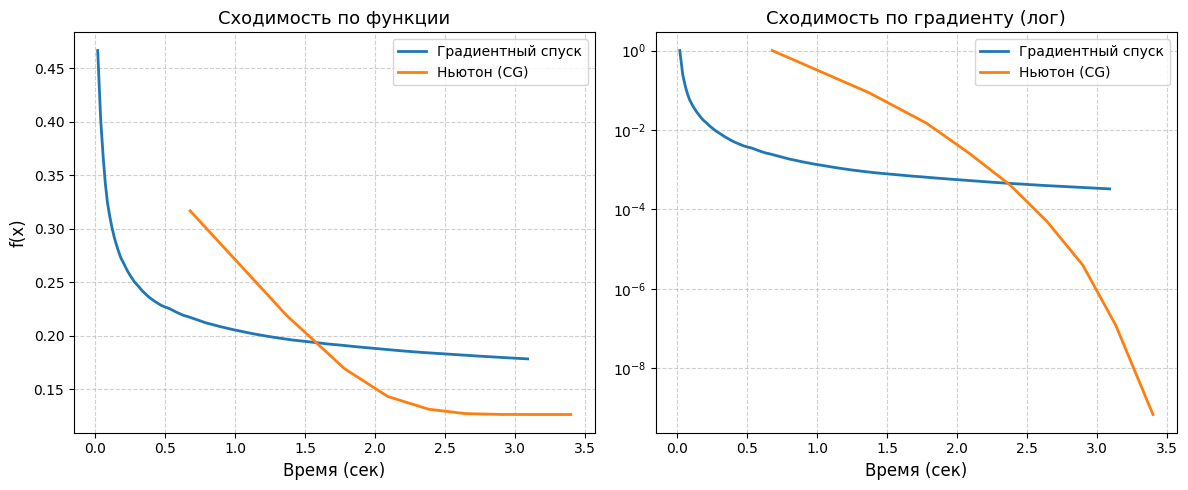

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time
from optimization import newton, gradient_descent
from oracles import create_log_reg_oracle, LogRegL2Oracle

X, y = load_svmlight_file("w8a.txt")
m, n = X.shape
print(f"Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = LogRegL2Oracle(X, y, regcoef)


x0 = np.zeros(n)


print("Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Описание левого графика:
График значения функции f(xk) (по оси y) в зависимости от времени выполнения (по оси x) для методов градиентного спуска (ГД) и метода Ньютона.

Оба метода демонстрируют быстрое уменьшение значения целевой функции f(x) с течением времени.

Метод Ньютона позволяет достичь более низкого значения функции быстрее, чем градиентный спуск, что свидетельствует о его более высокой эффективности в данном случае.

Градиентный спуск демонстрирует более постепенное снижение, что характерно для метода, основанного только на градиенте, особенно при больших объёмах данных и разреженности признаков.

Описание правого графика: Нормы градиента (по оси y, логарифмическая шкала) в зависимости от времени (по оси x).

Обе кривые демонстрируют экспоненциальное уменьшение нормы градиента, что говорит о хорошей сходимости методов.

Метод Ньютона демонстрирует более быстрое снижение нормы градиента, что подтверждает его эффективность и более высокую скорость сходимости.

Градиентный спуск демонстрирует более медленный спад, но всё равно приводит к минимуму.

Данные загружены: m=6000, n=5000
▶ Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.664613, ||grad||=2.556e+00, α=1.250e-01
Iter   10: f=0.299496, ||grad||=1.556e+00, α=3.906e-03
Iter   20: f=0.279056, ||grad||=1.037e+00, α=3.906e-03
Iter   30: f=0.263020, ||grad||=1.076e+00, α=3.906e-03
Iter   40: f=0.250871, ||grad||=7.299e-01, α=7.812e-03
Iter   50: f=0.238916, ||grad||=7.254e-01, α=3.906e-03
Iter   60: f=0.229441, ||grad||=5.132e-01, α=7.812e-03
Iter   70: f=0.221019, ||grad||=4.964e-01, α=7.812e-03
Iter   80: f=0.213067, ||grad||=5.398e-01, α=7.812e-03
Iter   90: f=0.206473, ||grad||=5.660e-01, α=7.812e-03
Iter  100: f=0.198929, ||grad||=4.487e-01, α=7.812e-03
Iter  110: f=0.193117, ||grad||=3.508e-01, α=1.562e-02
Iter  120: f=0.186842, ||grad||=3.100e-01, α=1.562e-02
Iter  130: f=0.180316, ||grad||=2.870e-01, α=1.562e-02
Iter  140: f=0.173874, ||grad||=2.938e-01, α=1.562e-02
Iter  150: f=0.166670, ||grad||=2.418e-01, α=3.125e-02
Iter  160: f=0.157710, ||grad||=1.

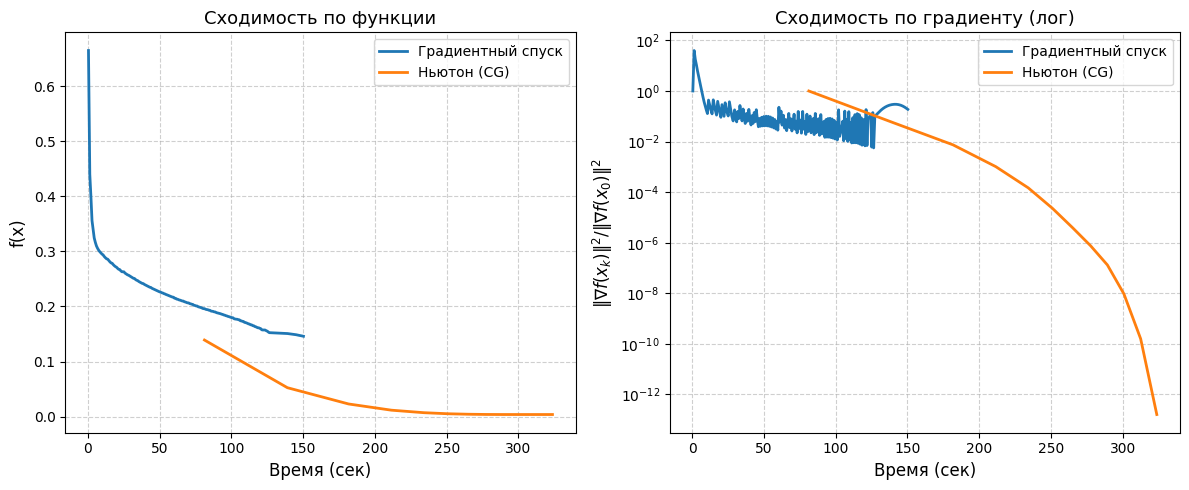

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time
from optimization import newton, gradient_descent
from oracles import create_log_reg_oracle, LogRegL2Oracle

X, y = load_svmlight_file("gisette_scale.bz2")
m, n = X.shape
print(f"Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = LogRegL2Oracle(X, y, regcoef)


x0 = np.zeros(n)


print("▶ Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Оба метода демонстрируют быстрое уменьшение значения целевой функции f(x) с течением времени.

Метод Ньютона позволяет достичь более низкого значения функции быстрее, чем градиентный спуск, что свидетельствует о его более высокой эффективности в данном случае.

Градиентный спуск демонстрирует более постепенное снижение, что характерно для метода, основанного только на градиенте, особенно при больших объёмах данных и разреженности признаков.

Обе кривые демонстрируют экспоненциальное уменьшение нормы градиента, что говорит о хорошей сходимости методов.

Метод Ньютона демонстрирует более быстрое снижение нормы градиента, что подтверждает его эффективность и более высокую скорость сходимости.

Градиентный спуск демонстрирует более медленный спад, но всё равно приводит к минимуму.

Данные загружены: m=72309, n=20958
Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.692046, ||grad||=3.321e-02, α=1.000e+00
Iter   10: f=0.681306, ||grad||=3.245e-02, α=1.000e+00
Iter   20: f=0.671048, ||grad||=3.172e-02, α=1.000e+00
Iter   30: f=0.661244, ||grad||=3.101e-02, α=1.000e+00
Iter   40: f=0.651869, ||grad||=3.033e-02, α=1.000e+00
Iter   50: f=0.642898, ||grad||=2.967e-02, α=1.000e+00
Iter   60: f=0.634307, ||grad||=2.904e-02, α=1.000e+00
Iter   70: f=0.626076, ||grad||=2.843e-02, α=1.000e+00
Iter   80: f=0.618182, ||grad||=2.785e-02, α=1.000e+00
Iter   90: f=0.610608, ||grad||=2.728e-02, α=1.000e+00
Iter  100: f=0.603333, ||grad||=2.674e-02, α=1.000e+00
Iter  110: f=0.596341, ||grad||=2.622e-02, α=1.000e+00
Iter  120: f=0.589616, ||grad||=2.572e-02, α=1.000e+00
Iter  130: f=0.583142, ||grad||=2.524e-02, α=1.000e+00
Iter  140: f=0.576906, ||grad||=2.478e-02, α=1.000e+00
Iter  150: f=0.570894, ||grad||=2.433e-02, α=1.000e+00
Iter  160: f=0.565093, ||grad||=2.

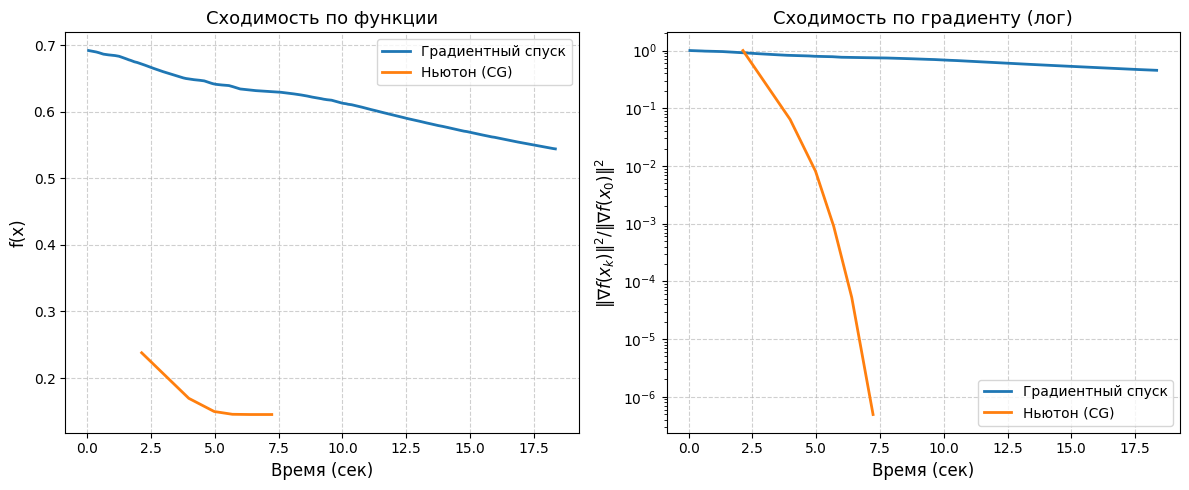

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time
from optimization import newton, gradient_descent
from oracles import create_log_reg_oracle, LogRegL2Oracle

X, y = load_svmlight_file("real-sim.bz2")
m, n = X.shape
print(f"Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = LogRegL2Oracle(X, y, regcoef)


x0 = np.zeros(n)


print("Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



Градиентный спуск: уменьшается плавно, с постепенной кривой, показывая стабильную сходимость.
В конце наблюдается некоторое снижение, но оно происходит медленнее, чем у метода Ньютона.

Метод Ньютона (CG): быстро достигает низких значений f(x), практически «выравниваясь» в конце.
Это свидетельствует о высокой эффективности второго порядка, особенно в ранних этапах.

Градиентный спуск: уменьшается относительно медленно, показывая более плавный, стабильный спад.
В конце остается более высоким уровнем градиента по сравнению с методом Ньютона.
Метод Ньютона (CG): значительно быстрее снижает норму градиента, достигая очень низких значений за короткое время.
Это говорит о более высокой скорости сходимости и эффективности второго порядка.